# Домашнее задание 4 (Визуализация данных) 

**Дано**: данные об оттоке клиентов некоторого банка

*Признаки:*
- *RowNumber* — номер строки таблицы (это лишняя информация, поэтому можете сразу от неё избавиться)
- *CustomerId* — идентификатор клиента
- *Surname* — фамилия клиента
- *CreditScore* — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их)
- *Geography* — страна клиента (банк международный)
- *Gender* — пол клиента
- *Age* — возраст клиента
- *Tenure* — сколько лет клиент пользуется услугами банка
- *Balance* — баланс на счетах клиента в банке
- *NumOfProducts* — количество услуг банка, которые приобрёл клиент
- *HasCrCard* — есть ли у клиента кредитная карта (1 — да, 0 — нет)
- *IsActiveMember* — есть ли у клиента статус активного клиента банка (1 — да, 0 — нет)
- *EstimatedSalary* — предполагаемая заработная плата клиента
- *Exited* — статус лояльности (1 — ушедший клиент, 0 — лояльный клиент)

**Цель**: установить, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов.


In [392]:
# импорт необходимых библиотек и данных
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
# для отображения статистических графиков в Jupiter Notebook на GitHub
pio.renderers.default = 'png' 

url = "https://raw.githubusercontent.com/yuliadm/homeworks-python/main/churn.csv"
churn_data = pd.read_csv(url)

#### 1. Каково соотношение ушедших и лояльных клиентов? Покажите это на графике и дайте комментарий по соотношению.

CustomerId    True
dtype: bool


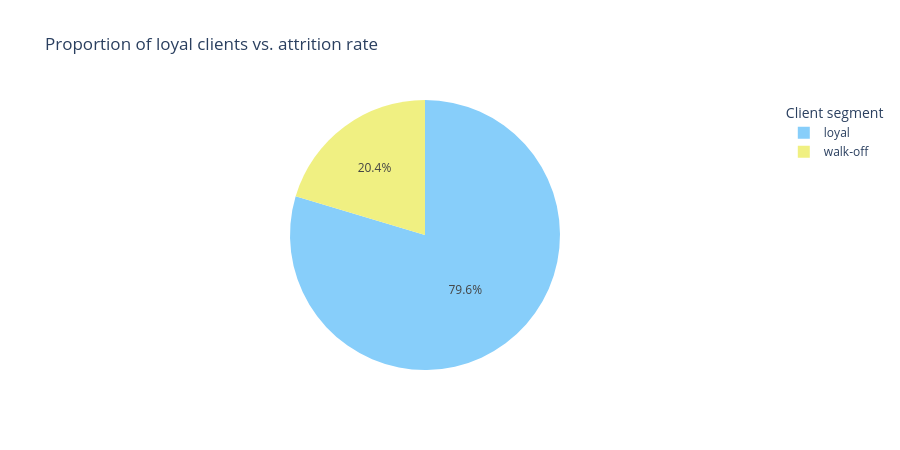

In [393]:
# проверяем, что все идентификационные номера уникальны
print(churn_data.shape[0] == churn_data[['CustomerId']].nunique())

# строим круговую диаграмму, т.к. нам необходимо изучить структуру признака.
df = churn_data[['Exited']].value_counts(normalize=False)
fig = px.pie(df, 
             values=df.values.tolist(), 
             names=['loyal','walk-off'], 
             color_discrete_sequence= ['rgb(135, 206, 250)', 'rgb(240, 240, 130)'],
             title='Proportion of loyal clients vs. attrition rate',
             height=450,
             width=900
            )
fig.update_layout(legend_title_text='Client segment')
fig.show()

**Комментарий**

Количество лояльных клиентов (7963, что составляет чуть менее 80% от общего числа клиентов) почти в 4 раза превосходит количество клиентов, переставших пользоваться услугами банка (2037, что составляет чуть более 20% от общего числа клиентов). 

Уровень оттока, составляющий 1/5 часть клиентов (даже за период времени более 10 лет, что следует из максимального значения для признака Tenure), является достаточно высоким и должен по крайней мере вызвать у руководства вопросы (если только он не связан с понижением общего тренда пользования банковскими услугами) в отношении качества предоставляемого сервиса, востребованности типов предлагаемых продуктов или привлекательности продуктов банка для клиентов в том виде, в котором они существуют.

#### 2. Постройте график, показывающий распределение баланса пользователей, у которых на счету больше 2 500 долларов. Опишите распределение и сделайте выводы.

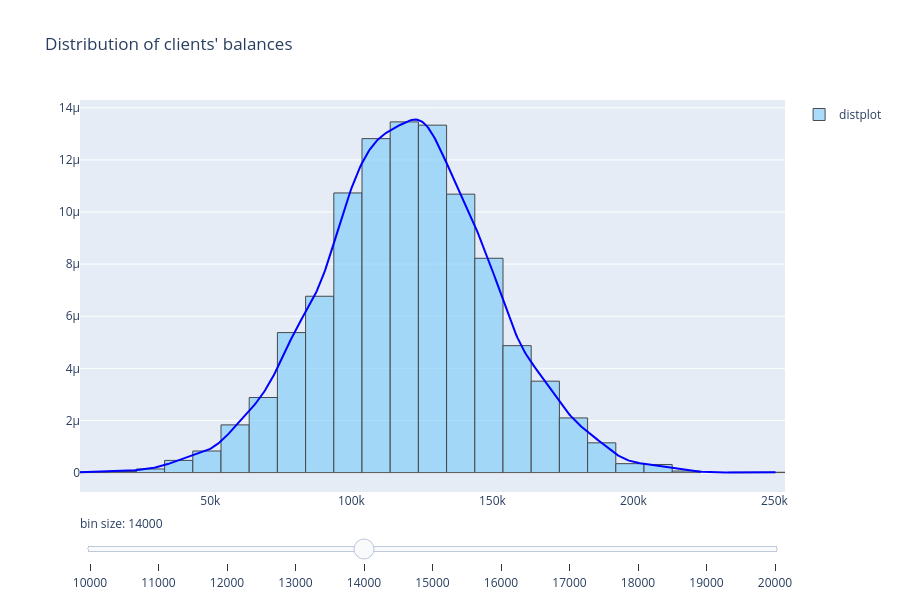

In [394]:
# фильтруем данные по балансам
df = churn_data[churn_data['Balance']>2500]['Balance']
group_labels = ['distplot']

# строим гистограмму по отфильтрованным данным
f = ff.create_distplot([df.tolist()], 
                       group_labels, 
                       bin_size=10000, 
                       show_rug=False,
                       colors=['rgb(135, 206, 250)']
                      )
fig = go.FigureWidget(f)
fig.data[0].marker.line =  dict( color = 'black', width = 1)
fig.data[1].line.color = 'blue'
# создаём возможность менять размер бина
fig.layout.sliders = [dict(
                active = 4,
                currentvalue = {"prefix": "bin size: "},
                pad = {"t": 20},
                steps = [dict(label = i, method = 'restyle',  
                              args = ['xbins.size', i]) for i in range(10000,21000,1000)]
            )]
# добавляем название графика, размеры
fig.update_layout(title="Distribution of clients' balances",
                 height=600,
                 width=900
                 ) 
fig.show()

**Комментарий**

Распределение балансов близко к нормальному, что следует из симметричной, колоколообразной формы гистограммы, и/или ядерной оценки плотности, представленной сплошной синей линией, и также имеющей колоколообразную форму. 
Касательно мер центральной тенденции: для нормального распределения мода = среднее = медиана, и здесь на глаз составляет около 120 тысяч долл. (хорошо видно, если размер бина взять менее 14000).

#### 3. Посмотрите на распределение баланса клиента в разрезе признака оттока. Как различаются суммы на накопительном счёте ушедших и лояльных клиентов? Подумайте и напишите, с чем это может быть связано, что может не устраивать ушедших клиентов в банке.

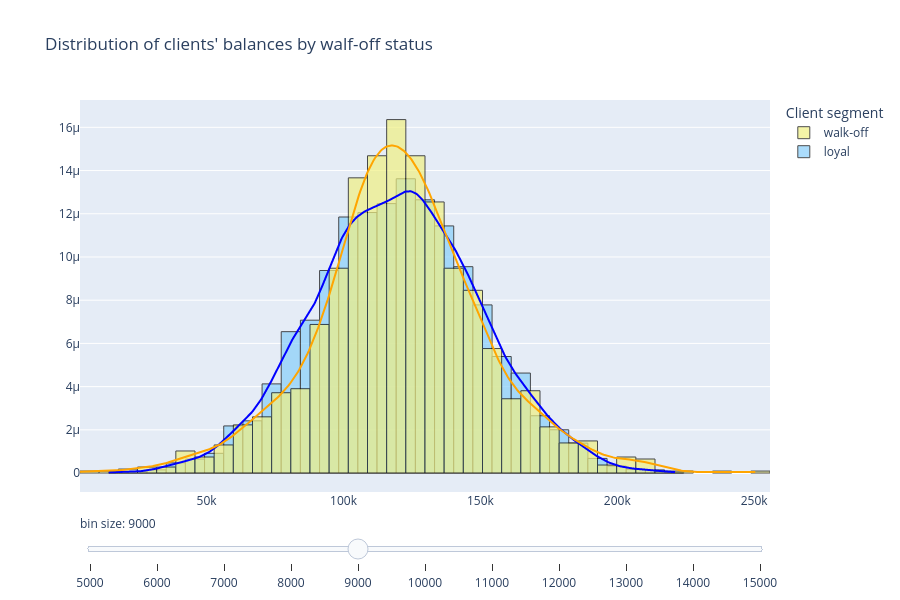

In [395]:
# фильтруем данные:
# для одного распределения берём только данные по лояльным клиентам, для другого - только по ушедшим
df0 = churn_data[(churn_data['Balance']>2500) & (churn_data['Exited']==0)]['Balance']
df1 = churn_data[(churn_data['Balance']>2500) & (churn_data['Exited']==1)]['Balance']

hist_data = [df0.tolist(), df1.tolist()]
group_labels = ['loyal', 'walk-off']

# строим две гистограммы наложением друг на друга, т.к. данные сопоставимы, и можно использовать одни и те же оси 
f = ff.create_distplot(hist_data, 
                       group_labels, 
                       bin_size=7000, 
                       show_rug=False,
                       colors=['rgb(135, 206, 250)', 'rgb(240, 240, 130)']
                      )
fig = go.FigureWidget(f)
fig.data[0].marker.line =  dict( color = 'black', width = 1)
fig.data[1].marker.line =  dict( color = 'black', width = 1)
fig.data[2].line.color = 'blue'
fig.data[3].line.color = 'orange'
# возможность менять размер бина
fig.layout.sliders = [dict(
                active = 4,
                currentvalue = {"prefix": "bin size: "},
                pad = {"t": 20},
                steps = [dict(label = i, method = 'restyle',  
                              args = ['xbins.size', i]) for i in range(5000,16000,1000)]
            )]
# добавляем название графика, регулируем размеры 
fig.update_layout(title="Distribution of clients' balances by walk-off status",
                  height=600,
                  width=900
                  ) 
# название легенды
fig.update_layout(legend_title_text='Client segment')
fig.show()

**Комментарий**

Непосредственно из описания переменной Balance не ясно, что отражают эти балансы: балансы ли это на дебетовых вкладах или же текущая задолженность по выданным кредитам.
Т.к. в вопросе использовано определение "накопительный" счёт, предположим, что речь идёт о текущих дебетовых счетах или сберегательных вкладах, хотя это не обязательно так.

Оба распределения по форме близки к нормальному. Модальное значение распределения, соответствующего балансам на счетах ушедших киентов, расположено чуть левее, чем модальное значение распределения, соответствующего балансам на счетах лояльных клиентов. Это говорит о том, что ушедшие клиенты в среднем имеют балансы на счетах чуть более низкие, чем лояльные клиенты. Скорее всего эта разница не является статистически значимой, что нуждается в дополнительной проверке.

Если это накопительные счета, то можно сказать, что ушедшие клиенты хранят в среднем в банке чуть меньше средств, чем лояльные клиенты. Возможно они располагают меньшими средствами, а возможно уровень доверия к этому финансовому институту у них несколько ниже. Если предположить, что всё же балансы отражают непогашенную часть займа, то нелояльные клиенты возможно берут кредиты на меньшие суммы, либо а целом быстрее их погашают. 

Распределение, соответствующее балансам на счетах ушедших киентов, также характеризуется более высоким значением куртозиса (распределение более островершинное). Значения балансов для этого распредеения более "центрированы" вокруг модального (или среднего) значения, т.е. разброс по балансам на счетах для ушедших клиентов несколько меньше, чем для лояльных.

В распределении, соответствующем балансам на счетах ушедших киентов, также наблюдается несколько нетипичных клиентов с очень высокими балансами (между 200 тыс. и 250 тыс. долл.).

В целом можно сделать вывод, что типичный клиент банка имеет на счёте около 120 тыс. ден. ед., и чуть более 95% распределения приходится на значения баланса между 50 тыс. и 200 тыс. долл.

Основываясь только на показателе балансов на счетах, сложно предположить, что послужило причиной отказа части клиентов от использования услуг данного финансового института: распределения балансов для лояльных клиентов и для ушедших клиентов различаются незначительно. Требуется исследование других признаков для выяснения причин оттока.  

Можно поспекулировать и предположить, что если в этом не сыграли роль какие-то внешние общеэкономические факторы, то либо конкуренты предлагают более выгодные условия по вкладам, кредитам и другим продуктам, либо уровень сервиса данного банка невысок по сравнению с уровнем сервиса, предлагаемого конкурентами, либо существуют проблемы с безопасностью, обращением с персональными данными или удобством совершения платежей, либо он уступает конкурентам по технологическим характеристикам, либо проводит слишком агрессивную политику Xsell, либо слишком жёсткую политику по сбору просроченной задолженности.

Возможно стали доступны новые инструменты инвестирования, и часть клиентов предпочла перевести средства со сберегательных вкладов в иные активы.
Возможно появились игроки на рынке с более выгодными условиями кредитования и часть клиентов решила провести рефинансирование (рефинансирование кредита в текущем банке предлагается редко, поэтому часто кредит для покрытия текущего кредита необходимо брать в другом банке).

Что могло бы объяснить то, что несмотря на неудовлетворительное обслуживание или невыгодные условия по кредитам или вкладам, достаточное большое количество клиентов всё же продолжает пользоваться услугами данного банка?
Инертность части пользователей менять что-либо в жизни: если они окрыли давно счёт в банке, то так им и пользуются по привычке, в том числе приобретают другие продуеты, даже несмотря на то, что существуют более привлекательные альтернативы. Это также может быть верно для зарплатных проектов (или в рамках программ лоотности): для зарплатников часто предлагаются более выгодные условия по кредитам - более низкая ставка, более низкий ежемесячный платёж, более длительный срок по кредиту, более длинный грейс-период или отсутствие штрафов за досрочное погашение. 

#### 4. Посмотрите на распределение возраста в разрезе признака оттока. В какой группе больше потенциальных выбросов? На какую возрастную категорию клиентов стоит обратить внимание банку?

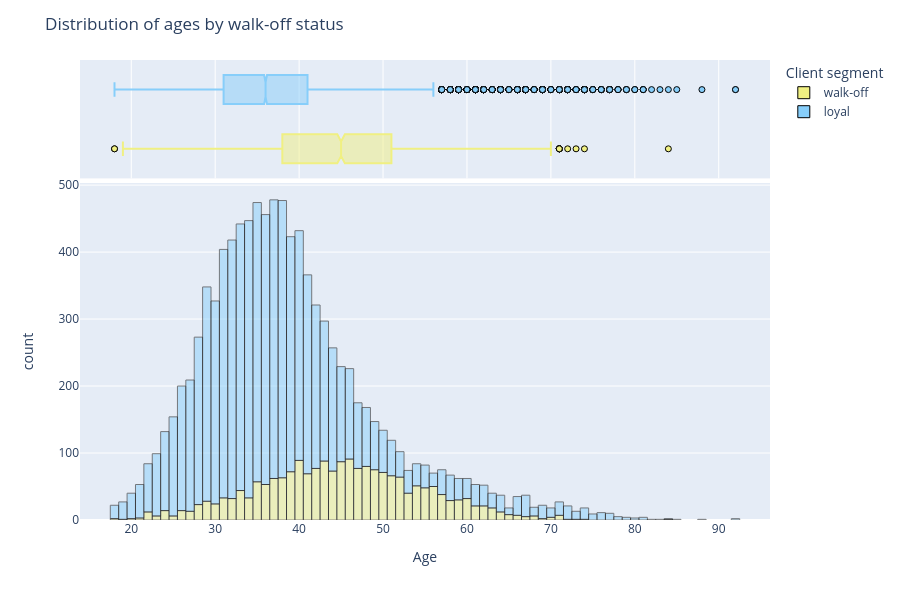

In [396]:
# т.к. требуется изучить распределение признака, будем смотреть на (ненормализованные) гистограммы и ящики с усами
df0 = churn_data[churn_data['Exited']==0]['Age']
df1 = churn_data[churn_data['Exited']==1]['Age']


df = churn_data[['Exited','Age']]
fig = px.histogram(df, x='Age', color='Exited', opacity=0.5, 
                   color_discrete_sequence=['rgb(240, 240, 130)', 'rgb(135, 206, 250)'], 
                   marginal='box')
fig.update_traces(marker_line_width=1, marker_line_color="black")

# добавляем название графика и устанавливаем размеры
fig.update_layout(title="Distribution of ages by walk-off status",
                 height=600,
                 width=900
                 ) 
# меняем ярлыки в легенде
newnames = {'0':'loyal', '1': 'walk-off'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
# меняем название легенды
fig.update_layout(legend_title_text='Client segment')
fig.show()

**Комментарий**

Возрастное распределение для лояльных клиентов имеет более низкое модальное значение - в районе 35 лет по 
сравнению с нелояльными клиентами, где мода равна примерно 46 годам, т.е. типичный лояльный клиент примерно 
на 10 лет моложе типичного нелояльного клиента.
Возрастное распределение для ушедших пользователей почти симметрично, в то время как распределение для лояльных 
сильно скошено вправо и имеет толстый правый хвост.

Судя по толстому правому хвосту, а также по значительному количеству наблюдений, находящихся за пределами правого 
уса ящика, характеризующего возрастное распределение для лояльных клиентов, в этой группе 
достаточно много выбросов в абсолютном отношении. Однако необходимо принимать в расчёт, что группа лояльных клиентов намного больше группы ушедших (это, в частности, видно по значениям частот), поэтому в процентном соотношении количество выбросов в двух группах может быть сопоставимым. Это требует дополнительной проверки.

На мой взгляд, гистограмма и ящики с усами - не оптимальный вариант для ответа на вопрос "На какую возрастную категорию клиентов стоит обратить внимание банку?". Поскольку тут речь идёт именно о возрастной группе, необходимо создать соответствующую переменную, объединив значения переменной Age таким образом, чтобы получилось 6-7 категорий и посмотреть на структуру возрастного признака в разрезе полученной переменной.  

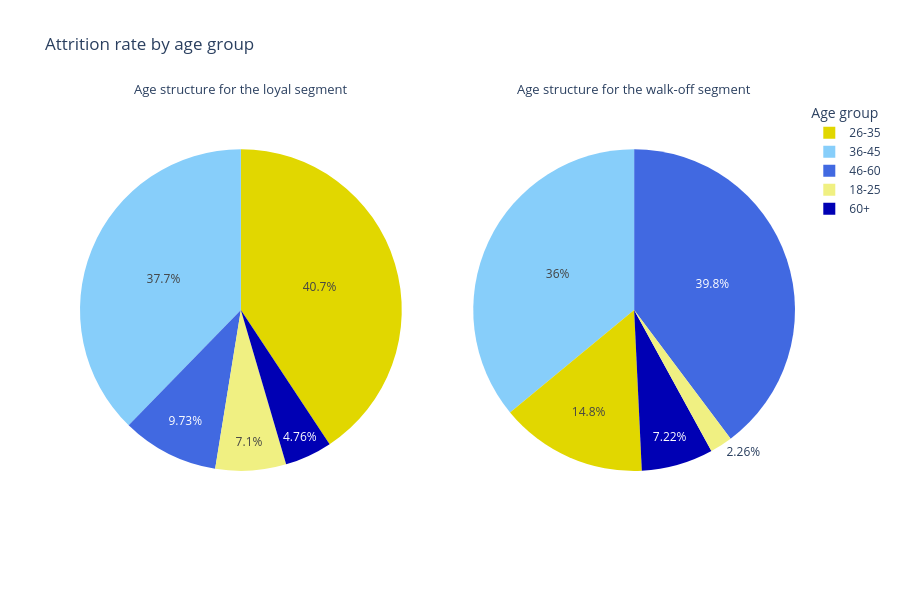

In [397]:
# строим две круговые диаграммы рядом:
# одна будет отражать возрастную структуру по ушедшим клиентам, вторая - по лояльным
fig = make_subplots(rows=1, cols=2, 
                    subplot_titles=('Age structure for the loyal segment',  'Age structure for the walk-off segment'),
                    specs=[[{"type": "pie"}, {"type": "pie"}]])

# создаем переменную с возрастными группами, иначе не удобно анализировать и строить графики
# определяем функцию для категоризации возрастного признака
def get_age_group(age):
    if age >= 18 and age < 26:
        return "18-25"
    elif age >= 26 and age < 36:
        return "26-35"
    elif age >= 36 and age < 46:
        return "36-45"
    elif age >= 46 and age < 60:
        return "46-60"
    elif age >= 60:
        return "60+"

df = churn_data[['Age', 'Exited']]
# применяем функцию по категоризации возраста к столбцу Age
df['AgeGroup'] = df['Age'].apply(get_age_group)
df = df.drop(['Age'], axis=1)
df = df.groupby(['AgeGroup']).value_counts().reset_index()

# фильтруем необходимые данные 
df0 = df[df['Exited']==0]
df1 = df[df['Exited']==1]

# строим круговые диаграммы
color_pal = ['rgb(240, 240, 130)','rgb(225, 215, 0)', 'rgb(135, 206, 250)', 'rgb(65, 105, 225)', 'rgb(0, 0, 180)']

fig.add_trace(go.Pie(
     values=df0.iloc[:,2].tolist(),
     labels=df0.iloc[:,0].tolist(),
     domain=dict(x=[0, 0.5]),
     name='loyal',
     marker=dict(colors=color_pal)
     ), 
     row=1, col=1)

fig.add_trace(go.Pie(
     values=df1.iloc[:,2].tolist(),
     labels=df1.iloc[:,0].tolist(),
     domain=dict(x=[0.5, 1.0]),
     name='walk-off',
     marker=dict(colors=color_pal)
     ),
     row=1, col=2)

# добавляем общее название диаграммы и легенды, регулируем размер
fig.update_layout(title='Attrition rate by age group', 
                  width=900, 
                  height=600,
                  legend_title='Age group' 
                  ) 
# уменьшаем шрифт названий каждой из диаграмм 
fig.update_annotations(font_size=13)
fig.show()

**Комментарий**

Возможно, что этот признак поможет чуть больше прояснить ситуацию с высоким уровнем оттока. 
Из этого графика видно, что среди лояльных клиентов преобладающая доля приходится на возрастную группу 26-35 (почти 41%). Следом идёт группа 36-45 (почти 38%). Вместе эти две группы составляют почти 80% всех лояльных клиентов.

Как известно, молодёжь достаточно высоко оценивает комфорт обслуживания, в том числе возможность совершать любые операции быстро, безопасно и без присутствия в отделениях банка. Соответственно, большое значение имеют такие факторы, как бесперебойная, быстрая и отлаженная работка интернет-банка и других мобильных и интернет приложений, высокий уровень защиты финансовых данных при осуществлении финансовых операций в интернете и бонусные программы (например, кэш-бэк). 

Скорее всего в этой ИТ-сфере проблем у банка нет, иначе бы отток наблюдался преимущественно среди молодых возрастов.  
Достаточно мала доля возрастной группы 46-60 среди лояльных клиентов. В то же время именно это группа составляет основу среди ушедших пользователей. Это является интересным наблюдением, т. к. с точки зрения психологии, люди этого возраста часто предпочитают стабильность во многих сферах жизни и менее склонны к переменам. Значит причины для смены банка должны быть достаточно вескими. 

Среди ушедших клиентов преобладающая доля приходится на возрастную группу 46-60 (почти 40%) и группа 36-45 (36%). Вместе эти две группы составляют более 3/4 всех ушедших клиентов. Учитывая тот факт,что эти группы составляют основу рабочей силы, имея уже приличный рабочий опыт, и многовероятно имеют стабильный доход, руководству банка надо задуматься об изменении стратегии в пользу удержания таких клиентов. Доля пенсионеров среди уходящих тоже выше, и не обязательно в силу только естественных причин.  

Не исключено, что данный банк слишком сильно ориентирован на цифровой подход, закрыл часть допофисов, убрал часть банкоматов и упразднил часть "классических" услуг с возможностью решения вопросов через сотрудников банка. В резкльтате пользователи, которые "не дружат" с мобильными приложениями и информационными технологиями в целом, были вынуждены либо осваивать новые навыки, либо отказаться от услуг этого банка в пользу более консервативных банков, где процессы выстроены более привычно и понятно.  

Гипотеза с рефинансированием тоже имеет место быть в этом случае. Люди более старшего возраста в силу опыта возможно более склонны находить подобные решения своих финансовых вопросов. 

#### 5. Постройте график, который показывает взаимосвязь кредитного рейтинга клиента и его предполагаемой зарплаты.  Добавьте расцветку по признаку оттока клиентов. Какова взаимосвязь между признаками?

Поскольку оба признака можно считать неприрывными (в некотором смысле, т. к. кредитный рейтинг может принимать 
большое количество значений), для определения характера зависимости можно попытаться построить диаграмму рассеяния.
Добавим также на полях графики, отражающие характеристики распределения каждого из признаков.

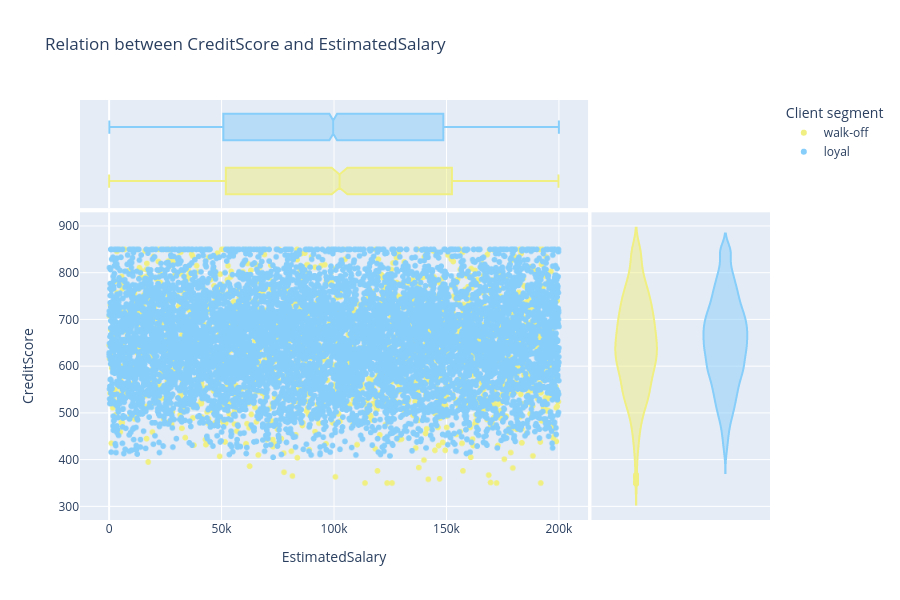

In [398]:
# фильтруем данные
df = churn_data[['EstimatedSalary', 'CreditScore', 'Exited']]
df['Exited'] = df['Exited'].astype(str)

# диаграмма рассеяния (без трансформации переменных)
fig = px.scatter(df, 
                 x='EstimatedSalary', 
                 y='CreditScore', 
                 color='Exited', 
                 color_discrete_sequence=['rgb(240, 240, 130)', 'rgb(135, 206, 250)'],
                 marginal_x="box", 
                 marginal_y="violin",
                 width=900, 
                 height=600,
                 title='Relation between CreditScore and EstimatedSalary'
                 )

# меняем ярлыки в легенде
newnames = {'0':'loyal', '1': 'walk-off'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
# меняем название легенды
fig.update_layout(legend_title_text='Client segment')
fig.show()

**Комментарий**

На диаграмме рассеяния мы не видим какой-либо структуры. Распределения обеих переменных не характеризуются скосом вправо, однако поскольку обе переменные могут принимать только положительные значения (и по крайней мере одна из них потенциально не ограничена сверху), можно попробовать применить к ним лог-трансформацию. Иногда трансформация помогает увидеть зависимость между переменными.

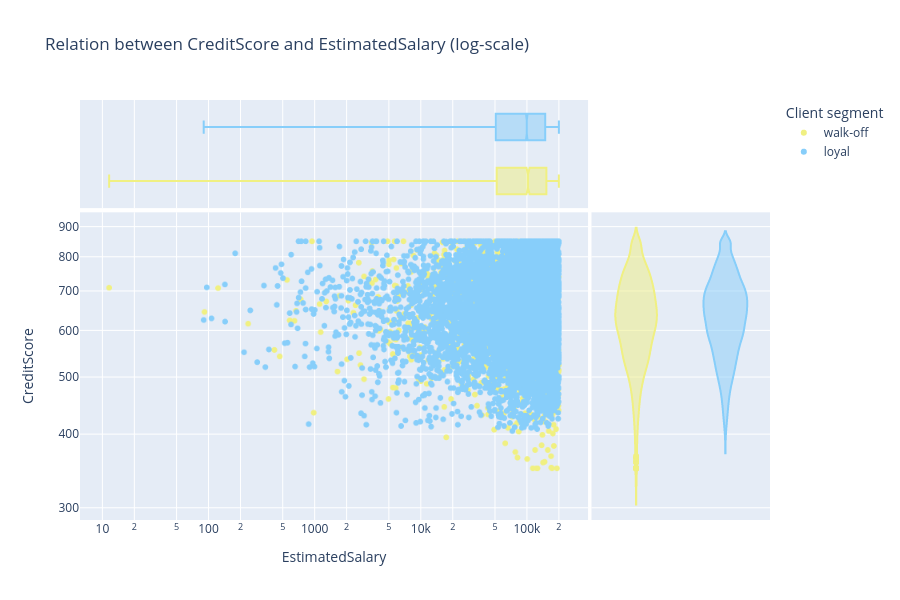

In [399]:
# пробуем также посмотреть на диаграмме рассеяния (логарифмическая шкала)
fig = px.scatter(df, 
                 x='EstimatedSalary', 
                 y='CreditScore', 
                 color='Exited', 
                 color_discrete_sequence=['rgb(240, 240, 130)', 'rgb(135, 206, 250)'],
                 log_x=True, 
                 log_y=True, 
                 marginal_x="box", 
                 marginal_y="violin",
                 width=900, 
                 height=600,
                 title="Relation between CreditScore and EstimatedSalary (log-scale)")
# меняем ярлыки в легенде
newnames = {'0':'loyal', '1': 'walk-off'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
# меняем название легенды
fig.update_layout(legend_title_text='Client segment')
fig.show()

Из данных графиков (как для без трансформации переменных, так без неё) не видно какой-либо зависимости между кредитным рейтингом пользователя и уровнем его предполагаемой зарплаты. Сложно предположить, что никакой зависимости между этими двумя признаками вообще нет. Возможно, здесь уравновешивают друг друга разнонаправленные эффекты. 

С одной стороны, может существовать положительная зависимость между уровнем предполагаемой зарплаты клиента и его кредитным рейтинг: чем больше зарплата, тем проще клиенту брать кредит и легче возвращать, следовательно, тем выше должен быть рейтинг. Не исключено, что это верно для части пользователей, которые активно пользуются услугами банка.

С другой стороны, при наличии достойного дохода можно подождать с приобретением товаров и услуг и накопить нужную сумму вместо того, чтобы брать кредит и его обслуживать. 

#### 6. Кто чаще уходит, мужчины или женщины? Постройте график, который иллюстрирует это. Процент ушедших клиентов в каждой группе можно рассчитать как среднее по столбцу Exited.

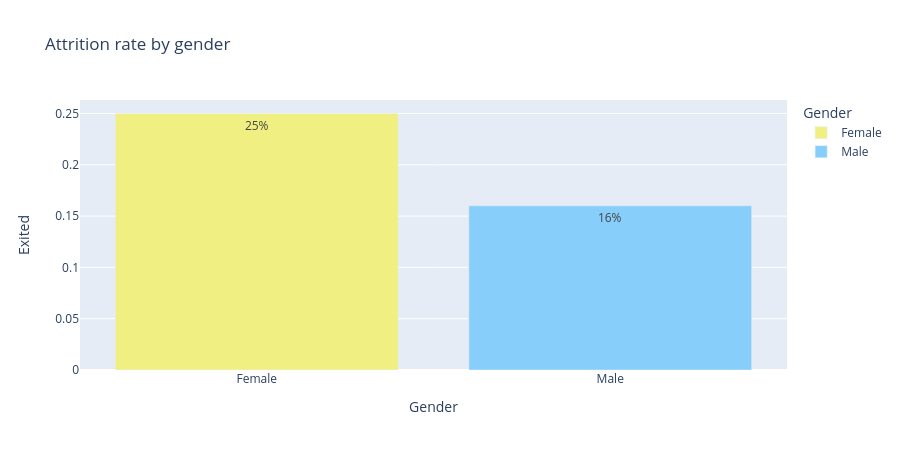

In [400]:
df = churn_data[['Gender', 'Exited']]


bar_data = df.groupby('Gender', as_index=False).mean().round(2)
fig = px.bar(
    data_frame=bar_data, 
    x='Gender', 
    y='Exited', 
    color_discrete_sequence=['rgb(240, 240, 130)', 'rgb(135, 206, 250)'],
    color='Gender', 
    text = 'Exited', 
    text_auto='.0%',
    orientation='v', 
    height=450, 
    width=900, 
    title='Attrition rate by gender' #заголовок
)
fig.show()


**Комментарий**

Уровень оттока среди женщин выше, чем среди мужчин: среди ушедших клиентов 25% составили женщины и всего 16% мужчины. 
Возможно, такое положение вещей обусловлено тем, что за финансы часто в семье отвечают мужчины. Если женщину что-то не устраивает в банке, ей легче отказаться от использования услуг банка вообще. Возможно, женщины менее склонны терпеть, нсли их что-то не устраивает.

Вариант графика выше мне не нравится, несмотря на то, что с точки зрения информативности он достаточен. Такой вариант мне кажется более наглядным:

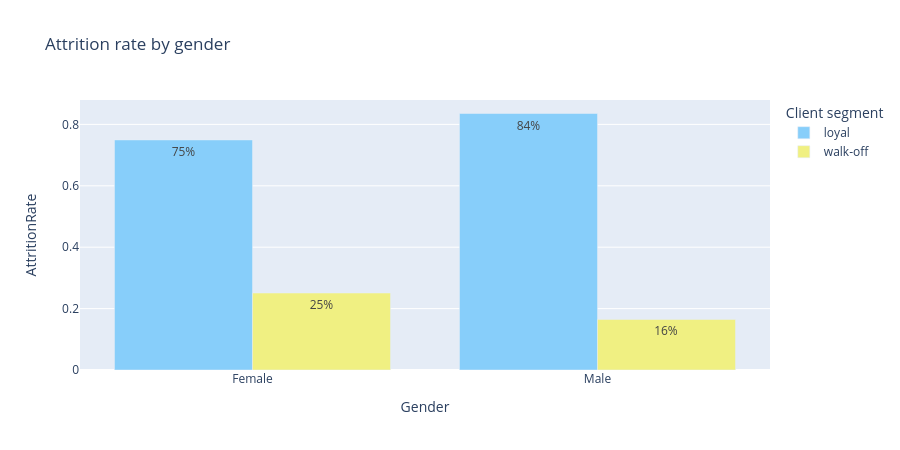

In [401]:
df = churn_data[['Gender', 'Exited']]

pivot = churn_data.pivot_table(
    values='CustomerId',
    index= ['Exited', 'Gender'],
    aggfunc = 'count'
)

pivot = pivot.set_axis(pivot.columns.tolist(), axis=1).reset_index()
bar_data = df.groupby('Gender', as_index=False).count()

df_=pivot.merge(bar_data, on=['Gender']) 
df_['AttritionRate'] = df_['CustomerId']/df_['Exited_y']
df_['Exited_x'] = df_['Exited_x'].astype(str)


fig = px.bar(df_[['Exited_x', 'Gender', 'AttritionRate']], 
             x='Gender', 
             y='AttritionRate',
             color='Exited_x', 
             color_discrete_sequence=['rgb(135, 206, 250)', 'rgb(240, 240, 130)'],
             text = 'Exited_x', #текст на столбцах
             text_auto='.0%',
             title='Attrition rate by gender',
             barmode='group',
             width=900,
             height=450)
# меняем ярлыки в легенде
newnames = {'0':'loyal', '1': 'walk-off'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
# меняем название легенды
fig.update_layout(legend_title_text='Client segment')
fig.show()

#### 7. Как отток клиентов зависит от числа приобретённых у банка услуг? Для ответа на этот вопрос постройте многоуровневую столбчатую диаграмму.

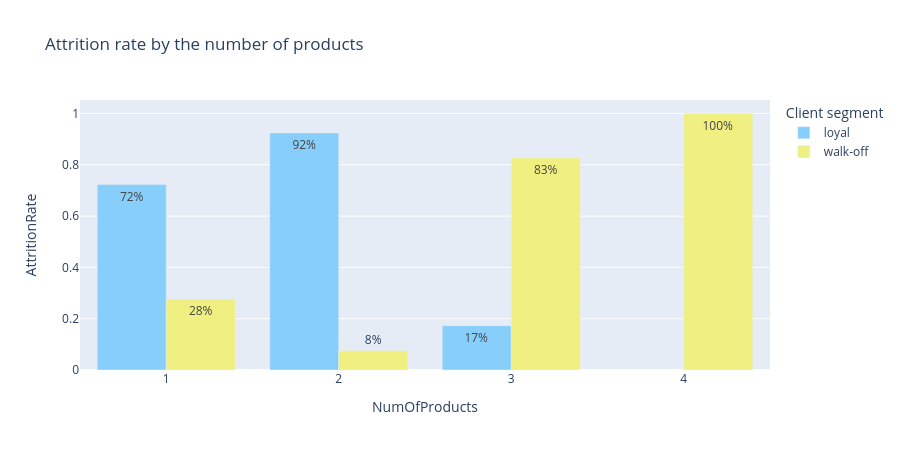

In [402]:
# фильтруем данные
df = churn_data[['Exited', 'NumOfProducts', 'CustomerId']]
df['Exited'] = df['Exited'].astype(str)

# строим сводную таблицу
pivot = churn_data.pivot_table(
    values='CustomerId',
    index= ['Exited', 'NumOfProducts'],
    aggfunc = 'count'
)

pivot = pivot.set_axis(pivot.columns.tolist(), axis=1).reset_index()
# для подсчёта отношений
# группируем данные по количеству продуктов (количество клиентов с каждым количеством продуктов)
bar_data = df.groupby('NumOfProducts', as_index=False).count()

# объединяем данные
df_=pivot.merge(bar_data, on=['NumOfProducts']) 
df_['AttritionRate'] = df_['CustomerId_x']/df_['Exited_y']
df_['Exited_x'] = df_['Exited_x'].astype(str)

# строим столбчатую диаграмму
fig = px.bar(df_[['Exited_x', 'NumOfProducts', 'AttritionRate']], 
             x='NumOfProducts', 
             y='AttritionRate',
             color='Exited_x', 
             color_discrete_sequence=['rgb(135, 206, 250)', 'rgb(240, 240, 130)'],
             text = 'Exited_x', 
             text_auto='.0%',
             title='Attrition rate by the number of products',
             barmode='group',
             width=900,
             height=450)
# меняем ярлыки в легенде
newnames = {'0':'loyal', '1': 'walk-off'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
# меняем название легенды
fig.update_layout(legend_title_text='Client segment')
fig.show()

Очень нетипичная картина: клиенты с большим количеством продуктов (3 или 4) с большей вероятностью отказываются от услуг банка. Наибольшая лояльность наблюдается среди группы клиентов, имеющей 2 продукта. Как минимум часть продуктов, предлагаемых банком, может быть не интересной клиентам, а то и вовсе их отталкивать.
Сложно предположить, почему это так. Надо сследовать, что это за продукты, на какую аудиторию они рассчитаны и какие именно категории клиентов ими пользуются или отказываются пользоваться.

#### 8. Как влияет наличие статуса активного клиента на отток клиентов? Постройте диаграмму, иллюстрирующую это.  Что бы вы предложили банку, чтобы уменьшить отток клиентов среди неактивных?


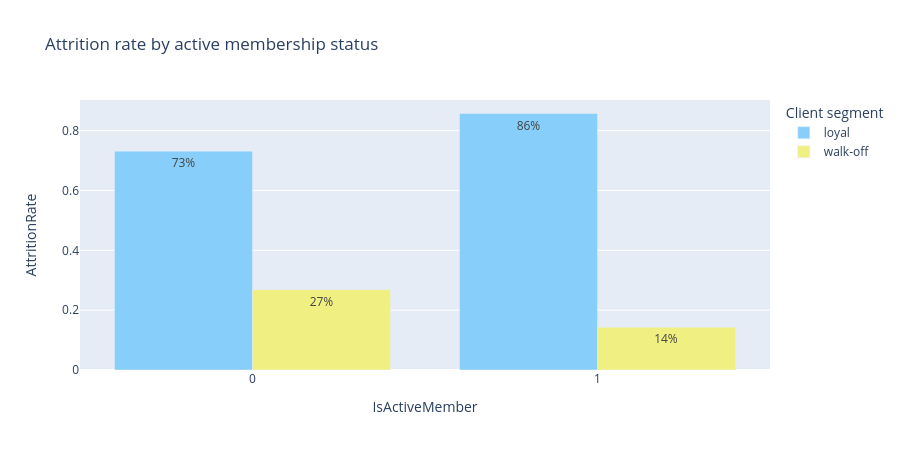

In [403]:
# отфильтровать данные 
df = churn_data[['IsActiveMember', 'Exited']]

# построить сводную таблицу
pivot = churn_data.pivot_table(
    values='CustomerId',
    index= ['Exited', 'IsActiveMember'],
    aggfunc = 'count'
)

pivot = pivot.set_axis(pivot.columns.tolist(), axis=1).reset_index()
# сгруппировать по признаку членства (количество членов и не-членов)
bar_data = df.groupby('IsActiveMember', as_index=False).count()

# объединить данные
df_=pivot.merge(bar_data, on=['IsActiveMember']) 
df_['AttritionRate'] = df_['CustomerId']/df_['Exited_y']
df_['Exited_x'] = df_['Exited_x'].astype(str)

# построить столбчатую диграмму
fig = px.bar(df_[['Exited_x', 'IsActiveMember', 'AttritionRate']], 
             x='IsActiveMember', 
             y='AttritionRate',
             color='Exited_x', 
             color_discrete_sequence=['rgb(135, 206, 250)', 'rgb(240, 240, 130)'],
             text = 'Exited_x', #текст на столбцах
             text_auto='.0%',
             title='Attrition rate by active membership status',
             barmode='group',
             width=900,
             height=450)
# меняем ярлыки в легенде
newnames = {'0':'loyal', '1': 'walk-off'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
# меняем название легенды
fig.update_layout(legend_title_text='Client segment')
fig.show()

Доля покинувших банк клиентов среди группы с наличием активного статуса значительно ниже, чем среди клиентов, не имеющих активного статуса (14% против 27%).

Чтобы уменьшить отток среди группы с неактивным статусом можно предложить им какие-то бонусы. Например, грейс-период по карте или периоды бесплатного пользования какими-то платными услугами. Можно предложить им попробовать поучаствовать в программе лояльности в течение пробного периода, а если понравится, то на постоянной основе.

#### 9. В какой стране доля ушедших клиентов больше? Постройте тепловую картограмму, которая покажет это соотношение на карте мира. Предположите, с чем это может быть связано.

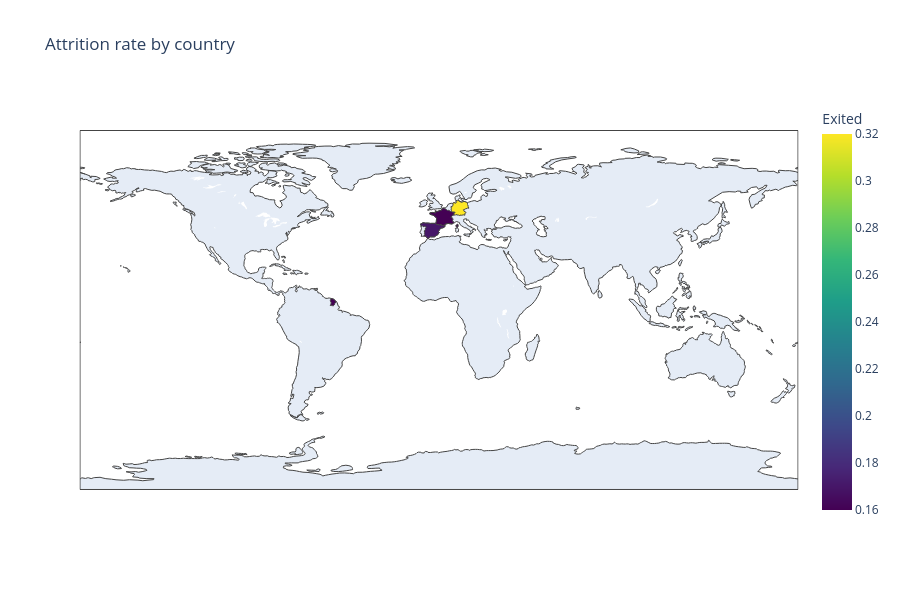

In [404]:
# отфильтровать данные
df = churn_data[['Geography', 'Exited']]
df = df.groupby('Geography', as_index=False).mean().round(2)
# возьмём непрерывную шкалу для доли оттока 
#df['Exited'] = df['Exited'].astype('string')

#строим график
fig = px.choropleth(
    data_frame=df, 
    locations='Geography', 
    locationmode='country names', 
    color='Exited', 
    title='Attrition rate by country', 
    width=900, 
    height=600, 
    color_continuous_scale='viridis'
)
fig.show()

На карте видно, что география банка представлена двумя регионами присутствия (Европа и Латинская Америка) и тремя странами: Франция (+ колония в Южной Америке), Германия и Испания.

Минимальный отток клиентов наблюдается во Франции (16%), чуть выше уровень оттока в Испании (17%). В Германии наблюдается самый высокий уровень оттока (32%).

Высокий уровень оттока в Германии может быть обусловлен тем, что в целом принято активно пользоваться банковскими услугами, соответственно много клиентов приходит и уходит, в частности, это может сочетаться с большим числом игроков в банковском секторе и высоким уровнем конкуренции. По той же причине рефинансирование может использоваться чаще.

В Испании и Франции шаблон поведения людей в отношении банков может быть иным: если в целом банковскими услугами приходится пользоваться редко, то можно и потерпеть неидеальный уровень сервиса, особенно если у конкурентов условия ненамного выгоднее.

#### 10. Переведите числовой признак CreditScore в категориальный с помощью функции get_credit_score_cat(). Постройте сводную таблицу, строками которой являются категории кредитного рейтинга (CreditScoreCat), а столбцами — количество лет, в течение которых клиент пользуется услугами банка (Tenure).  В ячейках сводной таблицы должно находиться среднее по признаку оттока (Exited) — доля ушедших пользователей. На основе полученной сводной таблицы постройте тепловую карту с аннотацией. Найдите на тепловой карте категории клиентов, которые уходят чаще всего.


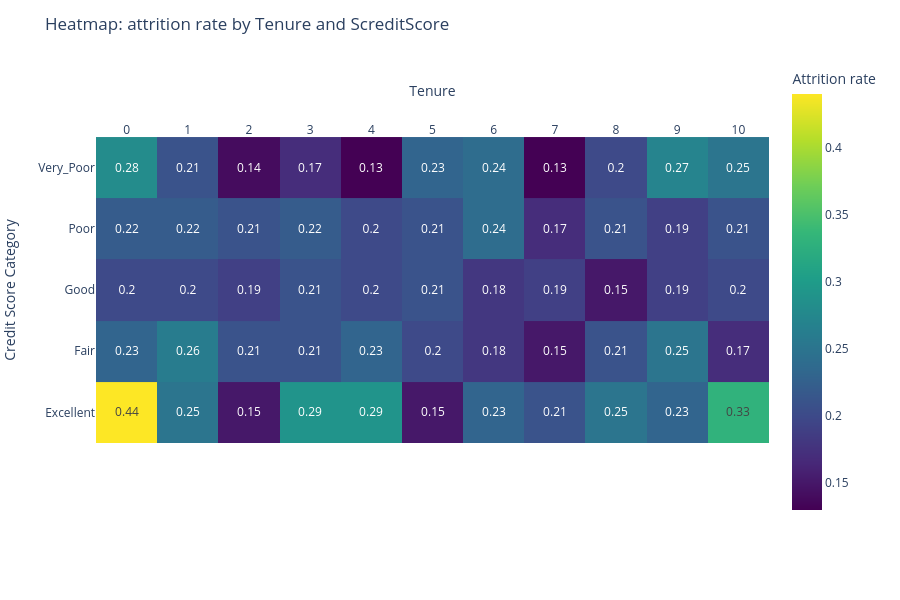

In [405]:
# задаём функцию для определения категорий
def get_credit_score_cat(credit_score):
    if credit_score >= 300 and credit_score < 500:
        return "Very_Poor"
    elif credit_score >= 500 and credit_score < 601:
        return "Poor"
    elif credit_score >= 601 and credit_score < 661:
        return "Fair"
    elif credit_score >= 661 and credit_score < 781:
        return "Good"
    elif credit_score >= 781 and credit_score < 851:
        return "Excellent"
    elif credit_score >= 851:
        return "Top"
    elif credit_score < 300:
        return "Deep"

# фильтруем данные и считаем категорию кредитного рейтинга CreditScoreCat
df = churn_data[['Geography', 'Exited', 'Tenure', 'CreditScore']]
df['CreditScoreCat'] = df['CreditScore'].apply(get_credit_score_cat)

# строим сводную таблицу согласно требованиям
pivot = df.pivot_table(
    values='Exited',
    index='CreditScoreCat',
    columns='Tenure',
    aggfunc='mean'
)

# строим тепловую карту
fig = px.imshow(np.round(pivot, 2),
                labels=dict(x='Tenure', y='Credit Score Category', color='Attrition rate'),
                x=pivot.columns.astype('string').tolist(),
                y=pivot.index.tolist()[::-1],
                color_continuous_scale='viridis',
                text_auto=True
               )
fig.update_xaxes(side="top")
# размеры карты и название 
fig.update_layout(
    width = 900,
    height = 600,
    title = "Heatmap: attrition rate by Tenure and ScreditScore"
)
fig.show()

Самый высокий отток наблюдается среди совсем новых пользователей с самым высоким кредитным кредитным рейтингом (уровень оттока 44%). Это интересный случай и возможно представлен выявленными случаями мошенничества (если речь идёт о кредитных продуктах и если существует какая-то возможность подделать кредитный рейтинг). А может это любители рефинансирования, которые внимательно отслеживают политику ЦБ, всегда ищут более выгодные условия и активно используют подобные финансовые инструменты. Также может быть, что это зарплатные клиенты, которым работодатель по умолчанию открывает счёт в данном банке, но они в течение нескольких месяцев успевают закрыть его и открыть в другом (или использовать уже существующий счёт в другом банке).  

Высокий отток наблюдается также среди клиентов с самым высоким кредитным рейтингом и сроками пользования услугами банка, равными 3, 4 года и 10 лет (уровень оттока примерно 29% и 33%), а также для пользователей с очень низким кредитным рейтингом и сроком пользования услугами банка 0 и 9 лет (28% и 27%).

Уход клиентов с самым высоким рейтингом после 10 лет может быть представлен людьми старшего возраста. Как правило, они очень исполнительные плательщики, а отток может возникать в силу естественных причин. 